In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

  Cloning https://github.com/undark-lab/swyft.git to /tmp/pip-req-build-oeom9ovv
  Running command git clone -q https://github.com/undark-lab/swyft.git /tmp/pip-req-build-oeom9ovv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.2 MB 6.8 MB/s 
     |████████████████████████████████| 23.2 MB 1.8 MB/s 
     |████████████████████████████████| 146 kB 50.1 MB/s 
     |████████████████████████████████| 1.0 MB 44.0 MB/s 
     |████████████████████████████████| 125 kB 49.5 MB/s 
     |████████████████████████████████| 791 kB 44.3 MB/s 
  Created wheel for swyft: filename=swyft-0.2.1.dev54+gd518f32-py3-none-any.whl size=59681 sha256=359e69545d17253b630c407048c7f3c38fcfc540b10ea66e7161ee5a45d3d5af
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpumlw21/wheels/2f/17/1b/d5a3f29a80fc800cada79f76285fe179aa7814cb106e5c16e2
  Created wheel for asciitree: filename=asciitree-0.3.3-py

# Using an External simulator

As demonstrated in the `Quickstart` notebook, `SWYFT`, of course, enables the user to define a simulator for use in the inferrence problem. Importantly, however, `SWYFT` also enables the user to employ *any* simulator callable from the command line.
This ensures that users can employ the simulators they are familiar with without having to worry about implementation etc.

In this notebook, based on the `Quickstart` example, we demonstrate the use of an external simulator.

NB: Here we demonstrate the use of `SWYFT`'s command line based simuulator invocation. The user can of course also write a python wraper to the simulator in question.

In [2]:
import numpy as np
import pylab as plt
import swyft

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #set to 'cpu if GPU not available
Ntrain =3000
Npars = 2

## Set input ... 

In order to make use of en external simulator called frrom the command line, the user must specify a function to setup the simulator input. It should take one input argument (the array with the input parameters), and return any input to be passed to the program via `stdin`. If the simulator requires any input files to be present, this function should write these to disk.

In [4]:
def set_input(v):
    v0 = v[0]
    v1 = v[1]
    v_str = str(v0).strip()+' '+str(v1).strip()
    return v_str

## ... output methods ...

Analogously, the user must define a function to retrieve results from the simulator output. It should take two input arguments (stdout and stderr of the simulator run) and return a dictionary with the simulator output shaped as described by the ``sim_shapes`` argument. If the simulator writes output to disk, this function **should** parse the results from the file(s).

In [5]:
def get_output(stdout,stderr):
    try:
        if not stderr :      
            x0,x1 = stdout.split(" ")
            x0 = np.float(x0.strip())
            x1 = np.float(x1.strip())
            x = np.array([x0,x1])
            return dict(x=x)

        else:
            raise('simulator returned on stderr')

    except:
        raise('Error in output retrieval')


In [6]:
import os
cwd = os.getcwd()

## ... and invocation

Here we use the cell magic `%%writefile` command to create an external python function `randgauss.py` containing the simulator defined as `model` in the Quickstart notebook. This function is then invoked from the command line.


In [8]:
 %%writefile randgauss.py 
#!/usr/bin/env python

import numpy as np
import sys



def rgmodel(v,sigma=0.05):
    x = v + np.random.randn(2)*sigma
    return x

def main():
    sigma = None
    args = sys.stdin.readline()
    arg1, arg2 = args.split(' ')
    try:
        v0 = float(arg1.rstrip())
        v1 = float(arg2.rstrip())
        
    except:
        raise()

    v = np.array([v0,v1])

    if sigma is not None:
        x = rgmodel(v,sigma=sigma)
    else:
        x = rgmodel(v)

    print(str(x[0]).strip()+' '+str(x[1]).strip())



if __name__ == "__main__":
    main()



Writing randgauss.py


It is up to the user to ensure adaquate permissions for all relevant files. 

In [ ]:
!chmod 755 randgauss.py
command = cwd+'/randgauss.py'


And to ensure that the root temporary directory in which the simulator is run exists.   Each instance of the simulator will run in a separate sub-folder.

In [ ]:
!mkdir -p ./tmp

## Defining the simulator
The simulator itslef can then be defined using the `from_command()` method of the `Simulator` class.

In [ ]:
simulator = swyft.Simulator.from_command(
    command=command,
    pnames=["x0","x1"],
    sim_shapes=dict(x=(Npars,)),
    set_input_method=set_input,
    get_output_method=get_output,
    tmpdir=cwd+'/tmp/',
    shell = False
)


**PLEASE NOTE**

The `from_command()` method of the `Simulator` class makes use of the `subprocess` module to execute a command line program or function. 

As for the `subprocess` module, the `shell` keyword is set to `False` by default. In some cases, the user may, however, want to execute their program or function via the shell, enabling the invocation and use of different environments, as well as featuures such as shell pipes, filename wildcards, environment variable expansion, and expansion of ~ to a user’s home directory.

This can be achived by setting `shell = True` in the `from_command()` method. 

We do, however, encourage the user to be aware of the security [considerations](https://docs.python.org/3/library/subprocess.html#security-considerations) connected to the use of `shell = True` in the `subprocess` module.

The remaining workflow is identical to that described in `Quickstart.ipynb`

In [ ]:
store = swyft.MemoryStore(simulator)

Creating new store.


In [ ]:
prior = swyft.Prior(lambda u: u*2-1, Npars)
store.add(Ntrain, prior)
store.simulate()

In [ ]:
dataset = swyft.Dataset(Ntrain, prior, store)
post = swyft.Posteriors(dataset)


In [ ]:
post.add([(0, 1)], device=DEVICE)
post.train([(0, 1)], max_epochs = 20)

Training: lr=0.001, Epoch=19, VL=0.5125


In [ ]:
v0 = np.zeros(Npars)
obs0 = {"x":[0.,0.]}

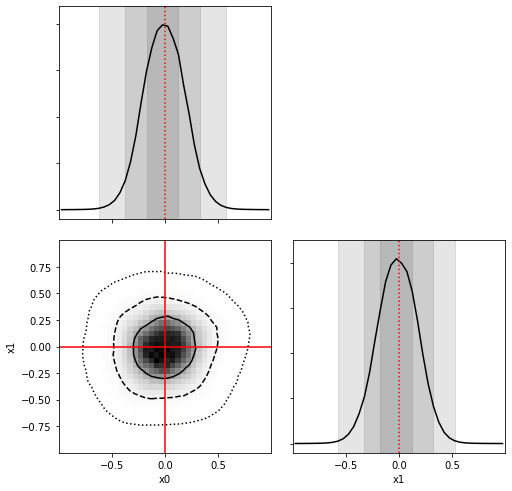

In [ ]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);